# ESOL

This Notebook uses the RDKit, ChemProp, and Delaney Dataset for ESOL.

Results are compared to MoleculeNet Paper (https://doi.org/10.1039/C7SC02664A)

Original ESOL Delaney Paper (https://pubs.acs.org/doi/10.1021/ci034243x)

ChemProp Paper (https://pubs.acs.org/doi/10.1021/acs.jcim.3c01250)

Author: James Roberts

# Imports

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

from chemprop import data, featurizers, models, nn

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import EarlyStopping

import pandas as pd
import numpy as np

import requests

from itertools import product

import torch
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.nn import GraphConv, NNConv, GATv2Conv, TransformerConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
import torch.optim as optim
from torchmetrics.regression import R2Score

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

import matplotlib.pyplot as plt

import random

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

# Importing molecules using SMILES

Acetaminophen SMILES representation: CC(=O)NC1=CC=C(O)C=C1

drugbank: https://go.drugbank.com/drugs/DB00316

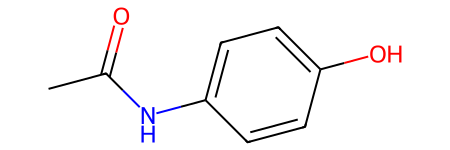

In [3]:
molecule = Chem.MolFromSmiles('CC(=O)NC1=CC=C(O)C=C1')
molecule

# Importing molecules using MOL

Acetaminophen MOL

pubchem: https://pubchem.ncbi.nlm.nih.gov/

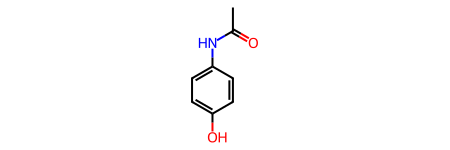

In [4]:
molecule_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/1983/SDF"
response = requests.get(molecule_url)
molecule = Chem.MolFromMolBlock(response.text)
molecule

# Molecular Coords

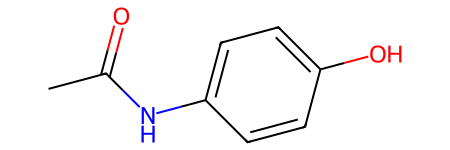

In [5]:
AllChem.Compute2DCoords(molecule)
molecule

# Descriptors

In [6]:
Descriptors.MolWt(molecule) # g/mol

151.16499999999996

In [7]:
print("LogP = log( [organic] / [aqueous] )")
print("LogP (RDkit, Predicted): ", Descriptors.MolLogP(molecule))
print("LogP (ALOGPS, Predicted): ", 0.51)
print("LogP (DrugBank, Measured): ", 0.46)

LogP = log( [organic] / [aqueous] )
LogP (RDkit, Predicted):  1.3505999999999998
LogP (ALOGPS, Predicted):  0.51
LogP (DrugBank, Measured):  0.46


# Delaney Dataset

From: https://moleculenet.org/datasets-1 (ESOL)

The task (Regression) is to predict the log solubility (mols/litre)

In [8]:
PATH_TO_DELANEY = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'
delaney_dataset = pd.read_csv(PATH_TO_DELANEY)
delaney_dataset.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [9]:
delaney_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

In [10]:
delaney_dataset.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


Done!


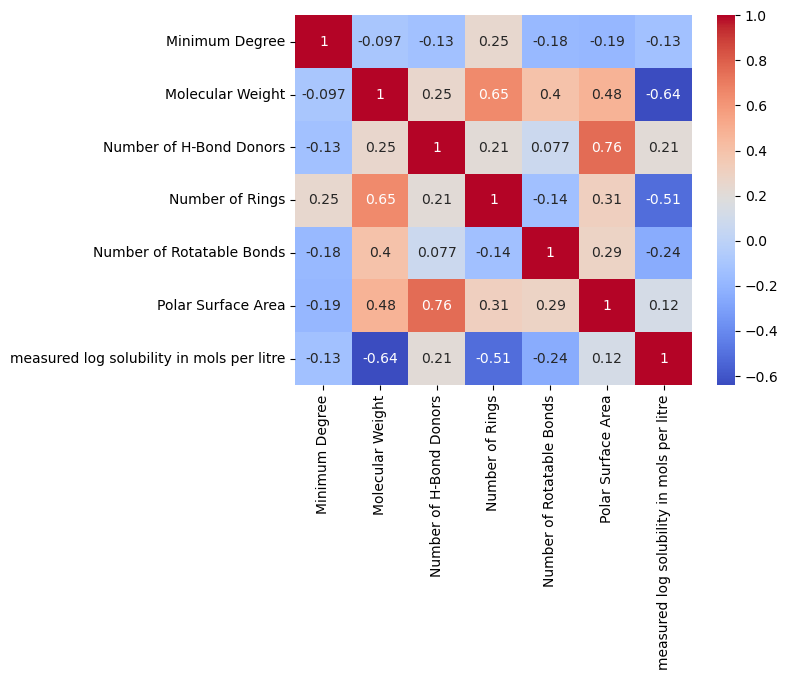

In [11]:
sns.heatmap(delaney_dataset.iloc[:, 2:9].corr(), annot=True, cmap='coolwarm')
print('Done!')

In [12]:
r2_ESOL = r2_score(delaney_dataset['ESOL predicted log solubility in mols per litre'], delaney_dataset['measured log solubility in mols per litre'])
print(f"ESOL R2: {r2_ESOL}")

ESOL R2: 0.707374251617849


## Preprocessing with ChemProp

In [13]:
def process_delaney_chemprop(delaney_dataset):
    # Get Data
    smiles_column = 'smiles'
    target_columns = ['measured log solubility in mols per litre']
    smis = delaney_dataset.loc[:, smiles_column].values
    ys = delaney_dataset.loc[:, target_columns].values
    
    # Molecule featurizer
    rdkit2d = featurizers.RDKit2DFeaturizer()

    # Apply it directly
    all_data = [data.MoleculeDatapoint.from_smi(smi, y, x_d=rdkit2d(Chem.MolFromSmiles(smi))) for smi, y, in zip(smis, ys)]
    
    # Split Data
    mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
    train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
    train_data, val_data, test_data = data.split_data_by_indices(
        all_data, train_indices, val_indices, test_indices
    )
    
    # Graph featurizer
    graph_featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
    
    train_dset = data.MoleculeDataset(train_data[0], graph_featurizer)
    scaler = train_dset.normalize_targets()
    x_d_scaler = train_dset.normalize_inputs("X_d")
    
    val_dset = data.MoleculeDataset(val_data[0], graph_featurizer)
    val_dset.normalize_targets(scaler)
    val_dset.normalize_inputs("X_d", x_d_scaler)
    
    test_dset = data.MoleculeDataset(test_data[0], graph_featurizer)
    test_dset.normalize_targets(scaler)
    test_dset.normalize_inputs("X_d", x_d_scaler)

    return train_dset, val_dset, test_dset

print("Done!")

Done!


In [14]:
train, val, test = process_delaney_chemprop(delaney_dataset)

print("\nAtom/Bond Level:")
print(f'V (atom features matrix) shape (num_atoms, num_atom_features): {train[0].mg.V.shape}')
print(f'E (bond features matrix) shape (num_bonds, num_bond_features): {train[0].mg.E.shape}')
print(f'edge_index (atom connectivity matrix) shape (2, num_bonds): {train[0].mg.edge_index.shape}')
print(f'rev_edge_index (reverse atom connectivity index) shape (num_bonds,): {train[0].mg.rev_edge_index.shape}')

print("\nMolecule Level:")
print(f'x_d (molecule-level features matrix) shape (num_mol_features,): {train[0].x_d.shape}')
print(f'y (target value for prediction) shape (num_targets,): {train[0].y.shape}\n')


The RDKit 2D features can deviate signifcantly from a normal distribution. Consider manually scaling them using an appropriate scaler before creating datapoints, rather than using the scikit-learn `StandardScaler` (the default in Chemprop).
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)



Atom/Bond Level:
V (atom features matrix) shape (num_atoms, num_atom_features): (7, 72)
E (bond features matrix) shape (num_bonds, num_bond_features): (14, 14)
edge_index (atom connectivity matrix) shape (2, num_bonds): (2, 14)
rev_edge_index (reverse atom connectivity index) shape (num_bonds,): (14,)

Molecule Level:
x_d (molecule-level features matrix) shape (num_mol_features,): (217,)
y (target value for prediction) shape (num_targets,): (1,)



# Models

## Custom GNN

In [15]:
class GNN(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.r2score = R2Score()

        self.graph_conv = kwargs.get('graph_conv_type')        
        
        in_channels = kwargs.get('in_channels')
        self.hidden_channels = kwargs.get('hidden_channels')
        
        mp_num_layers = kwargs.get('mp_num_layers')
        ffn_num_layers = kwargs.get('ffn_num_layers')
        
        x_d_size = kwargs.get('x_d_size')
        self.edge_dim = kwargs.get('edge_dim')
        
        self.dropout = kwargs.get('dropout')
        
        # Message Passing
        self.convs = torch.nn.ModuleList()
        self.batch_norms_convs = torch.nn.ModuleList()
        for i in range(mp_num_layers):
            self.convs.append(self.make_graph_conv(in_channels if i == 0 else self.hidden_channels))
            self.batch_norms_convs.append(torch.nn.BatchNorm1d(self.hidden_channels))

        # Aggregation
        self.aggr = pyg_nn.aggr.MeanAggregation()
        
        # Feed-Forward-Network
        self.ffns = torch.nn.ModuleList()
        self.batch_norms_ffs = torch.nn.ModuleList()
        for j in range(ffn_num_layers):
            self.ffns.append(torch.nn.Linear(self.hidden_channels + x_d_size, self.hidden_channels + x_d_size))
            self.batch_norms_ffs.append(torch.nn.BatchNorm1d(self.hidden_channels + x_d_size))

        # Output Layer
        self.out_layer = torch.nn.Linear(self.hidden_channels + x_d_size, 1)

    def forward(self, batch):
        V = batch.bmg.V

        # Message Passing
        for conv, bn in zip(self.convs, self.batch_norms_convs):
            V = self.use_graph_conv(conv, V, batch)
            V = bn(V)
            V = F.relu(V)
            V = F.dropout(V, p=self.dropout, training=self.training)

        # molecule-level embedding of Atom Features
        #V = self.pooling(V, batch.bmg.batch)
        V = self.aggr(V, batch.bmg.batch)
        
        # Concatenate molecule-level features
        if hasattr(batch, 'X_d'):
            V = torch.cat([V, batch.X_d], dim=1)

        # Feed-Forward-Network
        for ffn, bn in zip(self.ffns, self.batch_norms_ffs):
            V = ffn(V)
            V = bn(V)
            V = F.relu(V)
            V = F.dropout(V, p=self.dropout, training=self.training)

        output = self.out_layer(V)
        
        return output
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def make_graph_conv(self, in_channels):
        if self.graph_conv == "GraphConv":
            return GraphConv(in_channels, self.hidden_channels)

        elif self.graph_conv == 'NNConv':
            edge_mlp = pyg_nn.Linear(
                in_channels=self.edge_dim, 
                out_channels=in_channels * self.hidden_channels,
            )
            return NNConv(in_channels, self.hidden_channels, nn=edge_mlp)

        elif self.graph_conv == 'GATConv':
            return GATv2Conv(in_channels, self.hidden_channels, heads=1, edge_dim=self.edge_dim)

        elif self.graph_conv == 'TransformerConv':
            return TransformerConv(in_channels, self.hidden_channels, heads=1, edge_dim=self.edge_dim)

    def use_graph_conv(self, conv, V, batch):
        if self.graph_conv == "GraphConv":
            return conv(V, batch.bmg.edge_index)

        elif self.graph_conv == 'NNConv':
            return conv(V, batch.bmg.edge_index, batch.bmg.E)

        elif self.graph_conv == 'GATConv':
            return conv(V, batch.bmg.edge_index, batch.bmg.E)

        elif self.graph_conv == 'TransformerConv':
            return conv(V, batch.bmg.edge_index, batch.bmg.E)

    def training_step(self, batch, batch_idx):
        y_hat = self(batch)
        loss = F.mse_loss(y_hat, batch.Y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(batch)
        val_loss = F.mse_loss(y_hat, batch.Y)
        self.log("val_loss", val_loss, prog_bar=True)
        self.compute_metrics(y_hat, batch.Y, is_testing=False)

    def test_step(self, batch, batch_idx):
        y_hat = self(batch)
        test_loss = F.mse_loss(y_hat, batch.Y)
        self.log("test/mse", test_loss)
        self.compute_metrics(y_hat, batch.Y, is_testing=True)

    def compute_metrics(self, y_hat, y, is_testing=False):
        self.r2score.reset()
        self.r2score.update(y_hat, y)
        self.log("test/r2" if is_testing else "val/r2", self.r2score.compute(), prog_bar=True)
        

## ChemProp MPNN

In [16]:
def build_mpnn(x_d_size=7,
               graph_embedding_size=350,
               dropout=0.2,
               mp_num_layers=3,
               ffn_num_layers=1,
               batch_norm=True):
    
    mp = nn.BondMessagePassing(d_h=graph_embedding_size, depth=mp_num_layers)
    agg = nn.MeanAggregation()
    ffn = nn.RegressionFFN(input_dim=graph_embedding_size + x_d_size, n_layers=ffn_num_layers, dropout=dropout)
    return models.MPNN(mp, agg, ffn, batch_norm, [nn.metrics.MSE(), nn.metrics.R2Score()])
    

# Training Function

In [17]:
def train_and_test(model_name,
                   train_dset,
                   val_dset,
                   test_dset,
                   hidden_channels=128,
                   mp_num_layers=3,
                   ffn_num_layers=1,
                   batch_size=64,
                   dropout=0.2,
                   patience=15,
                   verbose=False):

    train_loader = data.build_dataloader(train_dset, batch_size=batch_size)
    val_loader = data.build_dataloader(val_dset, batch_size=len(val_dset), shuffle=False)
    test_loader = data.build_dataloader(test_dset, batch_size=len(test_dset), shuffle=False)
    
    checkpointing = ModelCheckpoint(
        f"checkpoints/{model_name}",  # Directory where model checkpoints will be saved
        "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
        "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
        mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
        save_last=True,  # Always save the most recent checkpoint, even if it's not the best
    )
    early_stop = EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    # Build Model chemprop mpnn or GNN
    if model_name == 'MPNN_ChemProp':
        model = build_mpnn(
            x_d_size=train_dset[0].x_d.shape[0],
            mp_num_layers=mp_num_layers,
            ffn_num_layers=ffn_num_layers,
            dropout=dropout
        )
            
    else:
        model = GNN(
            graph_conv_type=model_name,
            in_channels=train_dset[0].mg.V.shape[1],
            hidden_channels=hidden_channels,
            edge_dim=train_dset[0].mg.E.shape[1],
            x_d_size=train_dset[0].x_d.shape[0],
            mp_num_layers=mp_num_layers,
            ffn_num_layers=ffn_num_layers,
            dropout=dropout,
        )

    # Configure Traininer
    trainer = pl.Trainer(
        logger=False,
        enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
        enable_progress_bar=verbose,
        enable_model_summary=verbose,
        accelerator="auto",
        devices=1,
        max_epochs=400, # number of epochs to train for
        callbacks=[checkpointing, early_stop], # Use the configured checkpoint callback
    )
    
    # Train
    trainer.fit(model, train_loader, val_loader)

    # Best Validation Results
    val_results = trainer.validate(dataloaders=val_loader, ckpt_path='best')
    
    # Test
    test_results = trainer.test(dataloaders=test_loader, ckpt_path='best')

    return model, val_results, test_results
    

# Run Training

## Get Data

In [18]:
%%time
train_dset, val_dset, test_dset = process_delaney_chemprop(delaney_dataset)


The RDKit 2D features can deviate signifcantly from a normal distribution. Consider manually scaling them using an appropriate scaler before creating datapoints, rather than using the scikit-learn `StandardScaler` (the default in Chemprop).
The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


CPU times: total: 1min 24s
Wall time: 7.14 s


## Train and Test

In [20]:
%%time
verbose = False # Set to "True" to see full Training Process

model_names = ['MPNN_ChemProp', 'GraphConv', 'NNConv', 'GATConv', 'TransformerConv']

model_to_R2 = {}
for model_name in model_names:
    print(f"Model: {model_name}")
    model, val_results, test_results = train_and_test(
        model_name,
        train_dset,
        val_dset,
        test_dset,
        hidden_channels=350,
        mp_num_layers=4,
        ffn_num_layers=1,
        batch_size=64,
        dropout=0.2,
        patience=40,
        verbose=verbose
    )

    model_to_R2[model_name] = test_results[0]['test/r2']
    

Model: MPNN_ChemProp


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/mse          │    0.05358712747693062    │
│          val/r2           │    0.9393330216407776     │
│         val_loss          │    0.05358712002635002    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    0.07139736413955688    │
│          test/r2          │    0.9310786724090576     │
└───────────────────────────┴───────────────────────────┘

Model: GraphConv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/r2           │    0.9385775923728943     │
│         val_loss          │   0.054254353046417236    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    0.08167292922735214    │
│          test/r2          │    0.9211595058441162     │
└───────────────────────────┴───────────────────────────┘

Model: NNConv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/r2           │    0.9437346458435059     │
│         val_loss          │    0.04969913139939308    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    0.08800043910741806    │
│          test/r2          │    0.9150514006614685     │
└───────────────────────────┴───────────────────────────┘

Model: GATConv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/r2           │    0.9467225670814514     │
│         val_loss          │    0.04705993831157684    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    0.0797259658575058     │
│          test/r2          │     0.923038899898529     │
└───────────────────────────┴───────────────────────────┘

Model: TransformerConv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/r2           │    0.9428355693817139     │
│         val_loss          │    0.05049331858754158    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    0.08260400593280792    │
│          test/r2          │    0.9202606678009033     │
└───────────────────────────┴───────────────────────────┘

CPU times: total: 37min 28s
Wall time: 19min 19s


# Results On Delaney from MoleculeNet + Models above (R<sup>2</sup> )

2018-1-17

https://moleculenet.org/latest-results

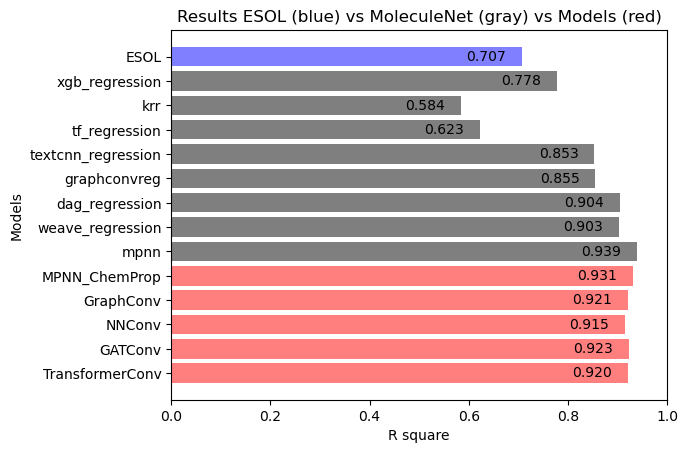

Done!


In [21]:
# Plot Results

# Results from MoleculeNet
labels = ['ESOL', 'xgb_regression', 'krr', 'tf_regression', 'textcnn_regression', 'graphconvreg', 'dag_regression', 'weave_regression', 'mpnn']
r2_all = [r2_ESOL, 0.778, 0.584, 0.623, 0.853, 0.855, 0.904, 0.903, 0.939]

# Results from Models above
labels += list(model_to_R2.keys())
r2_all += list(model_to_R2.values())

labels = labels[::-1]
r2_all = r2_all[::-1]

# Plotting
fig, ax = plt.subplots()
bars = ax.barh(range(len(labels)), 
               r2_all, 
               tick_label=labels, 
               color=['r' for i in range(5)] + ['k' for j in range(8)] + ['b'],
               alpha=0.5)

ax.bar_label(bars, fmt='%.3f', padding=-40)

plt.title('Results ESOL (blue) vs MoleculeNet (gray) vs Models (red)')
plt.ylabel('Models')
plt.xlabel('R square')
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

print('Done!')